In [2]:
!pip install unidecode

     |████████████████████████████████| 245kB 12.2MB/s 


In [3]:
import numpy as np 
import pandas as pd 


import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode


#import os
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer
#import spacy
#import string
#import re
from google.colab import drive 
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
#import nltk
#import operator
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [5]:
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")
df.shape

(141032, 20)

In [ ]:
for_tableau = pd.read_excel("for_tableau_2.xlsx")

In [ ]:
for_tableau['reassignment_count'] = df['reassignment_count']

In [ ]:
# for_tableau.to_excel('for_tableau_2.xlsx')

In [ ]:
df['calendar_duration']

0          14580
1          13287
2           4509
3            804
4           4151
           ...  
141027    813941
141028    203002
141029       164
141030     70529
141031    162073
Name: calendar_duration, Length: 141032, dtype: int64

In [ ]:
len(df)

141032

In [ ]:
def costum_tokenize(text):
  try:
    text = re.sub('\W+',' ', text)
    text = word_tokenize(text)
  except TypeError:
    text = 'NaN'
  
  return text

def freq_count(col):
  frq_dic = {}
  for lst in col:
    for i in lst:
      if i not in stop_words and i.isalpha():
        if i in frq_dic:
          frq_dic[i] += 1
        else:
          frq_dic[i] = 1
  return frq_dic

def split1(text):
  try:
    t = text[:19]
    return t
  except TypeError:
    return None

def split2(text):
  try:
    text = text[19:]
    return text
  except TypeError:
    return None

def clean_review(review):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))   
    return review.translate(replace_punctuation).lower()

def remodel (text):
  return ' '.join(word_tokenize(clean_review(text)))
  

In [ ]:
df2['category'].value_counts()

Application               45674
Hardware                  21088
VDI                       19196
Access                    15019
Telephony                 10240
End user equipment         7456
Mobile Device              6874
Integration                3492
Printing                   2919
Network                    2656
Monitoring                 1807
Store equipment            1346
Security                   1204
AV / Conf room              675
Facilities                  525
Server                      309
Database                    181
Data / Reporting            100
Storage                      82
Middleware                   31
Enterprise Application        3
Name: category, dtype: int64

In [ ]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN

# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [ ]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

# Random Sampling cross validation

In [ ]:
# X = df2.drop(['category'], axis=1)
# y = df2['category']
# x_train, y_train, x_test, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
x_train = vec_tdidf.fit_transform(train['short_description'])
x_test = vec_tdidf.transform(test['short_description'])
y_train = train['category']
y_test = test['category']

In [ ]:
import random

In [ ]:
#clf = XGBClassifier(random_state=42, objective="softmax")
m = int(train.shape[0]*0.3)

estimators = [50,100,150,200,300]

score = []
for i in range(5):
  new_train = train.sample(m)
  validation = train[~train.index.isin(new_train.index)]
  
  xtrain = vec_tdidf.fit_transform(new_train['short_description'])
  xval = vec_tdidf.transform(validation['short_description'])

  ytrain = new_train['category']
  yval = validation['category']
  
  acc_score = []
  for j in estimators:
    clf = XGBClassifier(random_state=42, n_estimators = j, objective="multi:softmax") #multi:softmax
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xval)
    acc = metrics.accuracy_score(yval, ypred)
    acc_score.append(acc)
  
  avg_score = np.mean(acc_score)
  score.append(avg_score)

In [ ]:
xgest_scores = pd.DataFrame(columns=['n_estimators', 'accuracy'])
xgest_scores['n_estimators'] = estimators
xgest_scores['accuracy'] = score

In [ ]:
xgest_scores
xgest_scores.to_csv("xgest_scores")

In [ ]:
index = xgest_scores[xgest_scores['accuracy']==max(xgest_scores['accuracy'])].index.values

est = xgest_scores['n_estimators'][index[0]]

clf_best = XGBClassifier(random_state=42, n_estimators = est, objective="softmax")
clf_best.fit(x_train,y_train)
y_pred = clf_best.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.6364809636480964

In [ ]:
metrics.auc(y_test, y_pred)

TypeError: ignored

In [ ]:
print(metrics.classification_report(y_test, y_pred))

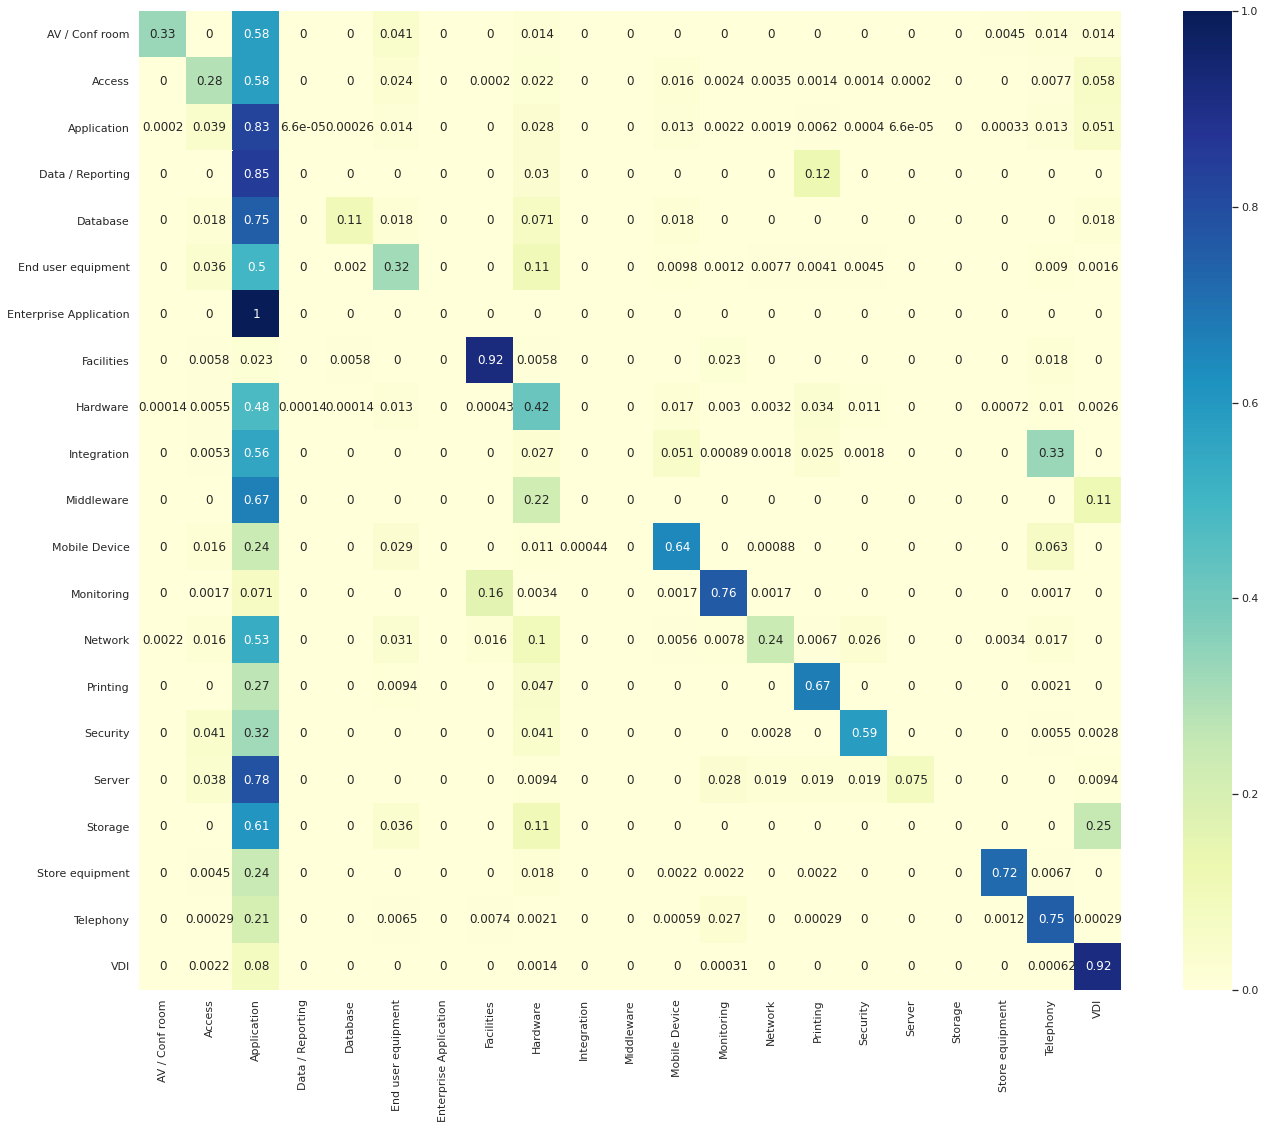

In [ ]:
labels = list(df2['category'].unique())
labels.sort()
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

##Improvement Analysis


In [6]:
!pip install unidecode

import numpy as np 
import pandas as pd 


import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode


#import os
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer
#import spacy
#import string
#import re
from google.colab import drive 
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
#import nltk
#import operator
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Mounted at /content/drive


In [7]:
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")
df.head()

,u_affected_application,sys_created_on,resolved_at,calendar_duration,state,impact,urgency,priority,description,short_description,u_knowledge_id.u_ci_class,category,reopen_count,reassignment_count,comments_and_work_notes,u_ci_class_name,cause,close_notes,Unnamed: 18,1
0,Cisco AnyConnect,1/31/2021 23:56,2/1/2021 3:58,14580,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,getting repeted sign-in dialogs in browser and...,NaN,Application,0,0,02-08-2021 04:34:31 - System (Additional comme...,Business Application,NaN,User connected to IDC two factor VPN and getti...,NaN,2
1,Driver,1/31/2021 23:54,2/1/2021 3:35,13287,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,Wifi adapter not connecting to network.,NaN,Application,0,0,02-08-2021 04:33:30 - System (Additional comme...,Business Application,NaN,As taken remote we found WIFI drivers and BIOS...,NaN,3
2,Cisco AnyConnect,1/31/2021 23:53,2/1/2021 1:07,4509,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,When im not on vpn my wifi speed is 40-50 Mbps...,NaN,Application,0,0,02-08-2021 01:36:40 - System (Additional comme...,Business Application,NaN,Requested user to use different Gateway of VPN...,NaN,4
3,Cisco AnyConnect,1/31/2021 23:48,2/1/2021 0:00,804,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Lost me vpn google Authenticator key , how can...",NaN,Application,0,0,02-08-2021 00:33:09 - System (Additional comme...,Business Application,NaN,Google Authenticator enrolled,NaN,5
4,NaN,1/31/2021 23:42,2/1/2021 0:51,4151,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Hi Team, I'm opening this service ticket on be...",NaN,Application,0,0,02-01-2021 00:51:27 - Santhosh Balu (Additiona...,Business Application,NaN,Issue resolved after connecting Wec 2 factor VPN,NaN,6


In [8]:
df2 = df[['category', 'short_description']].dropna()
#,"comments_and_work_notes"

In [11]:
def cleanText(text):
    text = re.sub('\W+',' ', text)
    text = text.lower()
    return ' '.join([t for t in text.split() if t not in stop_words])

df2['short_description'] = df2['short_description'].apply(cleanText)
#df2['comments_and_work_notes'] = df2['comments_and_work_notes'].apply(cleanText)

In [12]:
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
X = train.drop(['category'], axis=1)
y = train['category']
x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42)
x_test = test.drop(['category'], axis=1)
y_test = test['category']

In [13]:
!pip install catboost

from catboost import CatBoostClassifier, Pool

from_file = CatBoostClassifier()
from_file.load_model("catboost1")

yp = from_file.predict(x_test)

     |████████████████████████████████| 67.3MB 70kB/s 


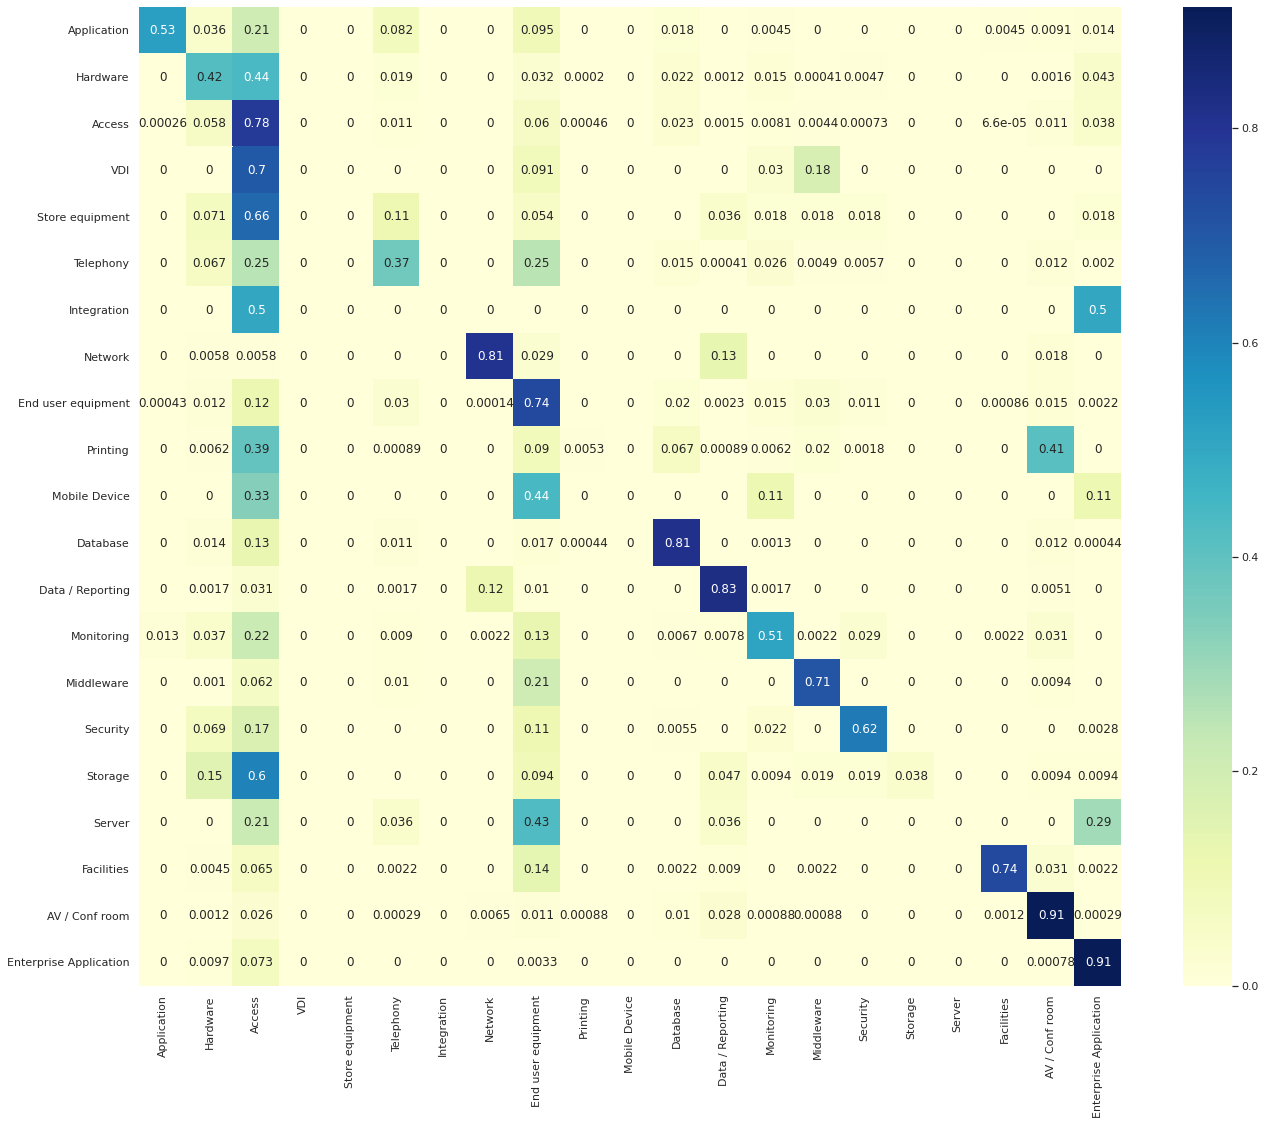

In [14]:
labels = list(df2['category'].unique())
cm=metrics.confusion_matrix(y_test, yp)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

In [15]:
print(metrics.classification_report(y_test, yp))

                        precision    recall  f1-score   support

        AV / Conf room       0.86      0.53      0.65       220
                Access       0.61      0.42      0.50      4918
           Application       0.68      0.78      0.73     15107
      Data / Reporting       0.00      0.00      0.00        33
              Database       0.00      0.00      0.00        56
    End user equipment       0.63      0.37      0.46      2452
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.59      0.81      0.68       171
              Hardware       0.69      0.74      0.71      6940
           Integration       0.33      0.01      0.01      1128
            Middleware       0.00      0.00      0.00         9
         Mobile Device       0.71      0.81      0.76      2265
            Monitoring       0.73      0.83      0.77       588
               Network       0.54      0.51      0.52       893
              Printing       0.68      

In [16]:
# cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# cm_df.to_csv('confusion matrix of predicting category accuracy.csv')

cm_df = pd.read_csv('confusion matrix of predicting category accuracy.csv') 

In [17]:
cm_df

,Unnamed: 0,Application,Hardware,Access,VDI,Store equipment,Telephony,Integration,Network,End user equipment,Printing,Mobile Device,Database,Data / Reporting,Monitoring,Middleware,Security,Storage,Server,Facilities,AV / Conf room,Enterprise Application
0,Application,0.527273,0.036364,0.209091,0.0,0.0,0.081818,0.0,0.000000,0.095455,0.000000,0.0,0.018182,0.000000,0.004545,0.000000,0.000000,0.000000,0.0,0.004545,0.009091,0.013636
1,Hardware,0.000000,0.421716,0.440220,0.0,0.0,0.018707,0.0,0.000000,0.031924,0.000203,0.0,0.021757,0.001220,0.014640,0.000407,0.004677,0.000000,0.0,0.000000,0.001627,0.042904
2,Access,0.000265,0.058251,0.782882,0.0,0.0,0.010657,0.0,0.000000,0.059840,0.000463,0.0,0.023433,0.001522,0.008142,0.004435,0.000728,0.000000,0.0,0.000066,0.011054,0.038260
3,VDI,0.000000,0.000000,0.696970,0.0,0.0,0.000000,0.0,0.000000,0.090909,0.000000,0.0,0.000000,0.000000,0.030303,0.181818,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,Store equipment,0.000000,0.071429,0.660714,0.0,0.0,0.107143,0.0,0.000000,0.053571,0.000000,0.0,0.000000,0.035714,0.017857,0.017857,0.017857,0.000000,0.0,0.000000,0.000000,0.017857
5,Telephony,0.000000,0.066884,0.250816,0.0,0.0,0.368271,0.0,0.000000,0.247961,0.000000,0.0,0.015090,0.000408,0.026101,0.004894,0.005710,0.000000,0.0,0.000000,0.011827,0.002039
6,Integration,0.000000,0.000000,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000
7,Network,0.000000,0.005848,0.005848,0.0,0.0,0.000000,0.0,0.807018,0.029240,0.000000,0.0,0.000000,0.134503,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.000000
8,End user equipment,0.000432,0.012104,0.119597,0.0,0.0,0.030115,0.0,0.000144,0.741066,0.000000,0.0,0.019597,0.002305,0.015274,0.029827,0.011095,0.000000,0.0,0.000865,0.015418,0.002161
9,Printing,0.000000,0.006206,0.390957,0.0,0.0,0.000887,0.0,0.000000,0.090426,0.005319,0.0,0.067376,0.000887,0.006206,0.019504,0.001773,0.000000,0.0,0.000000,0.410461,0.000000


In [18]:
confusion_values = []

for i in range(len(cm_df)):
  confusion_values.append(cm_df.iloc[i,i+1])

confusion_values

prediction_accuracy = pd.DataFrame(confusion_values, index=labels)
prediction_accuracy

,0
Application,0.527273
Hardware,0.421716
Access,0.782882
VDI,0.000000
Store equipment,0.000000
Telephony,0.368271
Integration,0.000000
Network,0.807018
End user equipment,0.741066
Printing,0.005319


In [19]:
df['reassignment_binary'] = df['reassignment_count']

def count_to_binary(i):
  if i > 0:
    return 0 
  
  else:
    return 1 # this is deliberately counterintuitive - we want 1 to represent when there is no reassignment, the category was interpreted correctly

df['reassignment_binary'] = df['reassignment_binary'].apply(count_to_binary)

reassignment_accuracy = df.groupby("category")[["reassignment_binary"]].mean()

reassignment_accuracy

,reassignment_binary
category,
AV / Conf room,0.794379
Access,0.685332
Application,0.708127
Data / Reporting,0.460000
Database,0.580110
End user equipment,0.685220
Enterprise Application,0.000000
Facilities,0.034286
Hardware,0.541351


In [20]:
accuracy_comparison = pd.concat([reassignment_accuracy,prediction_accuracy], join='outer', axis=1)

accuracy_comparison

,reassignment_binary,0
AV / Conf room,0.794379,0.913082
Access,0.685332,0.782882
Application,0.708127,0.527273
Data / Reporting,0.460000,0.829932
Database,0.580110,0.814128
End user equipment,0.685220,0.741066
Enterprise Application,0.000000,0.913057
Facilities,0.034286,0.741573
Hardware,0.541351,0.421716
Integration,0.652161,0.000000


In [21]:
accuracy_comparison_filtered = accuracy_comparison[accuracy_comparison[0] > accuracy_comparison['reassignment_binary']]

In [22]:
accuracy_comparison_filtered


,reassignment_binary,0
AV / Conf room,0.794379,0.913082
Access,0.685332,0.782882
Data / Reporting,0.460000,0.829932
Database,0.580110,0.814128
End user equipment,0.685220,0.741066
Enterprise Application,0.000000,0.913057
Facilities,0.034286,0.741573
Middleware,0.612903,0.708901
Monitoring,0.132817,0.511758
Network,0.657261,0.807018


In [23]:
accuracy_comparison_filtered.rename(columns={0:"accuracy"},inplace=True)

accuracy_comparison_filtered

,reassignment_binary,accuracy
AV / Conf room,0.794379,0.913082
Access,0.685332,0.782882
Data / Reporting,0.460000,0.829932
Database,0.580110,0.814128
End user equipment,0.685220,0.741066
Enterprise Application,0.000000,0.913057
Facilities,0.034286,0.741573
Middleware,0.612903,0.708901
Monitoring,0.132817,0.511758
Network,0.657261,0.807018


In [24]:
accuracy_comparison_filtered['improvement'] = accuracy_comparison_filtered['accuracy']/accuracy_comparison_filtered['reassignment_binary']

accuracy_comparison_filtered

,reassignment_binary,accuracy,improvement
AV / Conf room,0.794379,0.913082,1.149429
Access,0.685332,0.782882,1.142340
Data / Reporting,0.460000,0.829932,1.804200
Database,0.580110,0.814128,1.403402
End user equipment,0.685220,0.741066,1.081501
Enterprise Application,0.000000,0.913057,inf
Facilities,0.034286,0.741573,21.629213
Middleware,0.612903,0.708901,1.156627
Monitoring,0.132817,0.511758,3.853112
Network,0.657261,0.807018,1.227849


In [25]:
# Enterprise Application had all tickets being reassigned, but that makes any improvement infinity.
# For sake of interpretability, drop Enterprise Applications

accuracy_comparison_filtered = accuracy_comparison_filtered.drop(['Enterprise Application'])

accuracy_comparison_filtered

,reassignment_binary,accuracy,improvement
AV / Conf room,0.794379,0.913082,1.149429
Access,0.685332,0.782882,1.142340
Data / Reporting,0.460000,0.829932,1.804200
Database,0.580110,0.814128,1.403402
End user equipment,0.685220,0.741066,1.081501
Facilities,0.034286,0.741573,21.629213
Middleware,0.612903,0.708901,1.156627
Monitoring,0.132817,0.511758,3.853112
Network,0.657261,0.807018,1.227849


In [26]:
for_tableau = pd.read_excel("for_tableau_2.xlsx")

for_tableau['calendar_duration'] = df['calendar_duration']

In [27]:
for_regression = for_tableau[['category','reassignment_count','hour','calendar_duration']]

for_regression

chosen_categories = list(accuracy_comparison_filtered.index.unique())

for_regression = for_regression[for_regression['category'].isin(chosen_categories)]

In [28]:
for_regression

,category,reassignment_count,hour,calendar_duration
8,Access,0,23,5028
9,Access,0,23,5149
12,Access,0,23,20697
13,Access,0,23,21293
16,Access,0,22,7021
...,...,...,...,...
141008,AV / Conf room,0,8,66
141009,AV / Conf room,0,8,61
141010,AV / Conf room,0,8,203
141015,Network,1,7,1733585


In [29]:
def improvement_value(cat):
  return accuracy_comparison_filtered.loc[cat,'improvement']

for_regression['improvement'] = for_regression['category'].apply(improvement_value)

for_regression['reduced reassignment_count'] = for_regression['reassignment_count'] / for_regression['improvement']

for_regression

,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count
8,Access,0,23,5028,1.142340,0.000000
9,Access,0,23,5149,1.142340,0.000000
12,Access,0,23,20697,1.142340,0.000000
13,Access,0,23,21293,1.142340,0.000000
16,Access,0,22,7021,1.142340,0.000000
...,...,...,...,...,...,...
141008,AV / Conf room,0,8,66,1.149429,0.000000
141009,AV / Conf room,0,8,61,1.149429,0.000000
141010,AV / Conf room,0,8,203,1.149429,0.000000
141015,Network,1,7,1733585,1.227849,0.814432


In [ ]:
# current progress 4/20/21 3:00 pm

In [30]:
pooled_by_hrs = pd.read_excel('regression results_pooled_hours.xlsx')
pooled_by_hrs.set_index('Category', inplace=True)

# the "Unnamed: 1" column comes from an R regression of duration on reassignment count for combinations of category and hour
# the R code outputs the coefficients into a txt file, and then I hand-copied the coefficient values for all those combinations
# and averaged all the significant and positive ones by hours to get the below results

In [31]:
pooled_by_hrs

,Coefficients,Unnamed: 2
Category,,
AV / Conf room,444807,NaN
Access,410205,NaN
Data / Reporting,173611,NaN
Database,524508,NaN
End user equipment,543357,NaN
Facilities,0,original coefficient is negative and also not ...
Middleware,65292,NaN
Monitoring,89438,NaN
Network,359642,NaN


In [32]:
for_regression['reassignment_count reduction amount'] = for_regression['reassignment_count'] - for_regression['reduced reassignment_count']

def reassignment_to_duration_coefficient(cat):
  return pooled_by_hrs.loc[cat,'Coefficients']

for_regression['reassignment_to_duration_coefficient'] = for_regression['category'].apply(reassignment_to_duration_coefficient)

for_regression


,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count,reassignment_count reduction amount,reassignment_to_duration_coefficient
8,Access,0,23,5028,1.142340,0.000000,0.000000,410205
9,Access,0,23,5149,1.142340,0.000000,0.000000,410205
12,Access,0,23,20697,1.142340,0.000000,0.000000,410205
13,Access,0,23,21293,1.142340,0.000000,0.000000,410205
16,Access,0,22,7021,1.142340,0.000000,0.000000,410205
...,...,...,...,...,...,...,...,...
141008,AV / Conf room,0,8,66,1.149429,0.000000,0.000000,444807
141009,AV / Conf room,0,8,61,1.149429,0.000000,0.000000,444807
141010,AV / Conf room,0,8,203,1.149429,0.000000,0.000000,444807
141015,Network,1,7,1733585,1.227849,0.814432,0.185568,359642


In [33]:
for_regression['reduced calendar_duration'] = for_regression['calendar_duration'] - \
for_regression['reassignment_count reduction amount'] * for_regression['reassignment_to_duration_coefficient']

In [34]:
for_regression

,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count,reassignment_count reduction amount,reassignment_to_duration_coefficient,reduced calendar_duration
8,Access,0,23,5028,1.142340,0.000000,0.000000,410205,5.028000e+03
9,Access,0,23,5149,1.142340,0.000000,0.000000,410205,5.149000e+03
12,Access,0,23,20697,1.142340,0.000000,0.000000,410205,2.069700e+04
13,Access,0,23,21293,1.142340,0.000000,0.000000,410205,2.129300e+04
16,Access,0,22,7021,1.142340,0.000000,0.000000,410205,7.021000e+03
...,...,...,...,...,...,...,...,...,...
141008,AV / Conf room,0,8,66,1.149429,0.000000,0.000000,444807,6.600000e+01
141009,AV / Conf room,0,8,61,1.149429,0.000000,0.000000,444807,6.100000e+01
141010,AV / Conf room,0,8,203,1.149429,0.000000,0.000000,444807,2.030000e+02
141015,Network,1,7,1733585,1.227849,0.814432,0.185568,359642,1.666847e+06


In [50]:
improvement_comp = for_regression.groupby("category")[["calendar_duration","reduced calendar_duration"]].sum()

improvement_comp['duration improvement'] = (improvement_comp['calendar_duration'] - improvement_comp['reduced calendar_duration']) \
                                            / improvement_comp['calendar_duration']                                                                                

improvement_comp['duration improvement amount'] = improvement_comp['duration improvement'] * improvement_comp['calendar_duration']

improvement_comp['duration improvement amount in years'] = improvement_comp['duration improvement amount'] / 3600 / 24 / 365

improvement_comp

,calendar_duration,reduced calendar_duration,duration improvement,duration improvement amount,duration improvement amount in years
category,,,,,
AV / Conf room,209094293,1.975869e+08,0.055035,1.150741e+07,0.364897
Access,6715338852,6.319110e+09,0.059004,3.962292e+08,12.564346
Data / Reporting,100943781,9.258620e+07,0.082794,8.357577e+06,0.265017
Database,143568256,1.224608e+08,0.147020,2.110745e+07,0.669313
End user equipment,4356254352,4.196356e+09,0.036705,1.598983e+08,5.070342
Facilities,94079152,9.407915e+07,0.000000,0.000000e+00,0.000000
Middleware,29132232,2.874320e+07,0.013354,3.890329e+05,0.012336
Monitoring,622844299,4.499279e+08,0.277624,1.729164e+08,5.483143
Network,2063276017,1.964237e+09,0.048001,9.903914e+07,3.140510


In [51]:
improvement_overall = (for_regression['calendar_duration'].sum() - for_regression['reduced calendar_duration'].sum()) \
                      / for_regression['calendar_duration'].sum()
                      
improvement_overall

0.060653849601756314

In [52]:
improvement_overall_amt = improvement_overall * for_regression['calendar_duration'].sum()

improvement_overall_amt_yrs = improvement_overall_amt / 3600 / 24 / 365
improvement_overall_amt_yrs

27.569904286488914

In [1]:
## THIS SLIDE HAS NOTHING TO DO WITH CAPSTONE, JUST USING THIS AS A TEMPLATE TO DO ARITHMETIC
from math import sqrt

number_list = [0.7*sqrt(3)+0.7**2*sqrt(2), sqrt(1)+0.7*sqrt(3)+0.7**2*sqrt(1), sqrt(2)+0.7*sqrt(2)+0.7**2*sqrt(1), sqrt(3)+0.7*sqrt(1)+0.7**2*sqrt(1), sqrt(4)+0.7*sqrt(1)+0.7**2*sqrt(0), sqrt(5)+0.7*sqrt(0)+0.7**2*sqrt(0)]
max_value = max(number_list)

max_index = number_list.index(max_value)

max_index

max_value


2.9220508075688767

In [4]:
## THIS SLIDE IS JUST MISCELLANEOUS ARITHMETIC FOR CAPSTONE
ratio_1 = 128960240 / 102403568
ratio_2 = 34992177 / 17309805

ratio_3 = (128960240 - 102403568) / 128960240
ratio_4 = (34992177 - 17309805) / 34992177

ratio_3

0.20592914529315393

In [7]:
## THIS SLIDE IS JUST MISCELLANEOUS ARITHMETIC FOR CAPSTONE

years_900 = (128960240 - 102403568) / 3600 / 24 / 365

years_2100 = (34992177 - 17309805) / 3600 / 24 / 365

years_900

0.8421065449010654

In [ ]:
category_tickets_breakdown = df.groupby("category")[["comments_and_work_notes"]].count() # display count of tickets for each category

total_tickets = category_tickets_breakdown['comments_and_work_notes'].sum()
relevant_categories_tickets = category_tickets_breakdown[category_tickets_breakdown.index.isin(chosen_categories)]['comments_and_work_notes'].sum()

proportion_tickets_relevant = relevant_categories_tickets / total_tickets

proportion_tickets_relevant

0.2019751648928995

In [ ]:
for_regression.to_csv('predict duration.csv') 
for_regression.to_excel('predict duration.xlsx')

In [ ]:
# X = for_regression[['category','reassignment_count','hour']]
# y = for_regression['calendar_duration']

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(interaction_only=True,include_bias = False)
# poly.fit_transform(X)

# without cv tfidf

In [ ]:
# clf = XGBClassifier(random_state=42, objective="softmax")

In [ ]:
# param_grid = {
#      'clf__n_estimators': [50,100,300]
#      #'lambda': 
#      #'clf__colsample_bytree': [0.6,0.8,1]
#      #'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
# }

# grid_search = GridSearchCV(estimator = clf, cv = 3, param_grid = param_grid)

In [ ]:
# grid_search.fit(x_train, y_train)

In [ ]:
# grid_search.best_params_
# clf_test = grid_search.best_estimator_

In [ ]:
# preds = clf_test.predict(x_test)

In [ ]:
# metrics.accuracy_score(y_test, preds)

In [ ]:
# print(metrics.classification_report(y_test, preds))

In [ ]:
# labels = df2['category'].unique()
# cm=metrics.confusion_matrix(y_test, preds)
# cm = cm / np.sum(cm, axis=1)[:,None]
# fig_size=(22,18)
# sns.set(rc={'figure.figsize':fig_size})
# sns.heatmap(cm, 
#     xticklabels=labels,
#     yticklabels=labels,
#         annot=True, cmap = 'YlGnBu')
# plt.pause(0.05)

# Catboost

In [ ]:
# pip install catboost

In [ ]:
# from catboost import CatBoostClassifier, Pool

In [ ]:
# train, test = train_test_split(df2, test_size = 0.33, random_state=42)
# X = train.drop(['category'], axis=1)
# y = train['category']
# x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42)

# x_test = test.drop(['category'], axis=1)
# y = test['category']

In [ ]:
# text_features = ['short_description']
# train_pool = Pool(
#     x_train,
#     y_train,
#     text_features = text_features,
#     feature_names = list(x_train)
# )


# valid_pool = Pool(
#     x_valid,
#     y_valid,
#     text_features = text_features,
#     feature_names = list(x_valid)
# )

# catboost_params = {
#     'iterations': 3000,
#     'learning_rate': 0.01,
#     'eval_metric': 'AUC',
#     'early_stopping_rounds': 1000,
#     'od_type': 'Iter',
#     'use_best_model': True
# }

# cmodel = CatBoostClassifier(**catboost_params)

In [ ]:
# #text_features = [0]
# cmodel.fit(train_pool, eval_set=valid_pool, plot=True)

In [ ]:
# y_pred = cmodel.predict(x_test)

In [ ]:
# metrics.accuracy_score(y, y_pred)

In [ ]:
# print(metrics.classification_report(y, y_pred))

In [ ]:
# labels = df2['category'].unique()
# cm=metrics.confusion_matrix(y, y_pred)
# cm = cm / np.sum(cm, axis=1)[:,None]
# fig_size=(22,18)
# sns.set(rc={'figure.figsize':fig_size})
# sns.heatmap(cm, 
#     xticklabels=labels,
#     yticklabels=labels,
#         annot=True, cmap = 'BuPu')
# plt.pause(0.05)

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(cmodel, 'catboost1.pkl')

# Undersampling

In [ ]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

In [ ]:
# dic = {}
# for i in df2['category']:
#   dic[i] = 20

# over = SMOTE(sampling_strategy=dic)
# #under = RandomUnderSampler(sampling_strategy=dic)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

In [ ]:
# x_train,y_train = over.fit_resample(x_train,y_train)